### **Zero-Shot Noise2Noise: Efficient Image Denoising without any Data**


# **Step 1: Device Selection**
**If you choose 'cuda' remember to change your colab runtime to GPU via 'Runtime' -> 'Change runtime type'.**

In [7]:
#Enter device here, 'cuda' for GPU, and 'cpu' for CPU
device = 'cuda'

# **Step 2: Import Libraries and why we need to use them**


In [8]:
import numpy as np  # for numerical calculations and array operations.
import matplotlib.pyplot as plt  # for plotting and visualizing data and images.
from tqdm.notebook import tqdm  # to display progress bars for loops.
import torch  # for deep learning and tensor-based computations.
import torch.nn as nn  # Contains modules and classes for building neural networks in PyTorch.
import torch.optim as optim  # Contains optimizers for training neural networks in PyTorch.
import torch.nn.functional as F  # Contains commonly used functions for neural networks in PyTorch.
from PIL import Image  # for image processing and manipulation.
from torchvision import transforms  # Contains common image transformations and datasets for PyTorch.
import os  # for operating system functions like file paths and directory operations.

# **Step 3: Install Necessary Packages**

In [3]:
!pip install torch torchvision pillow  # Installs PyTorch, torchvision, and Pillow for deep learning and image processing tasks

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

# **Step 4: Upload the image from either a local computer (Option 1) or Google Drive (Option 2)**





Do you want to upload an image from your local computer or use an image from Google Drive? (Enter 'local' or 'drive'): drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


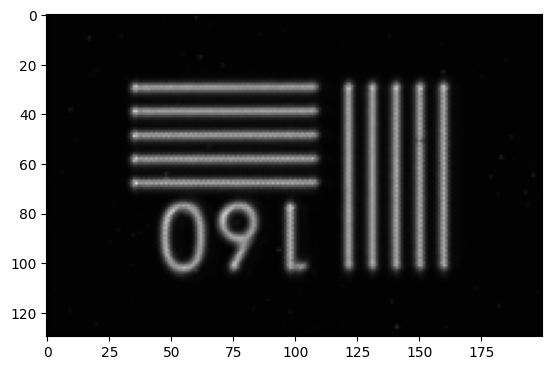

In [9]:
from google.colab import files
from google.colab import drive
# Option 1: Upload image from local computer

def upload_and_display_image():
    uploaded = files.upload()  # Allow user to upload a file
    if uploaded:
        for filename in uploaded.keys():
            image_path_local = filename
            img = Image.open(filename)
            plt.imshow(img)
            plt.axis('off')  # Turn off axis numbers and ticks
            plt.show()
        return image_path_local
    return None

# Option 2: Upload image from Google Drive

def display_image_from_drive(image_path):
    drive.mount('/content/drive')  # Mount Google Drive
    img = Image.open(image_path)
    plt.imshow(img)
    plt.show()
    return image_path

# Ask user for their choice
choice = input("Do you want to upload an image from your local computer or use an image from Google Drive? (Enter 'local' or 'drive'): ").strip().lower()

if choice == 'local':
    image_path = upload_and_display_image()
elif choice == 'drive':
    image_path_clean = '/content/drive/MyDrive/RAML_reduced_dataset/1.png'
    image_path = display_image_from_drive(image_path_clean)
else:
    print("Invalid choice. Please enter 'local' or 'drive'.")
    image_path = None

# **Step 5: Load and Transform Image**


This enhancement was introduced to provide users with the flexibility to use any image they prefer. Originally, the system was limited to using images from the Kodak24 dataset through URL links. To incorporate their own images, users must upload them to Google Drive and copy the corresponding path, ensuring that the image is accessible and processable by anyone with the link. We have streamlined this process by allowing users to upload images directly from their computers or Google Drive.

The research paper and the initial code consistently worked with a fixed image size of 256x256 pixels to align with the study "Self2self with dropout: Learning self-supervised denoising from a single image." To facilitate comparative analysis, our code has been adapted to convert all images to this 256x256 format. However, users can adjust this setting as needed using the 'transforms.Resize' function.

While the original code was restricted to processing only color images, our updated version offers users the choice to either maintain color or convert images to grayscale. This adaptability is particularly beneficial for analyzing microscopic images where reducing data complexity and highlighting structural information is more crucial than color detail. Converting to grayscale accelerates processing, enhances consistency, and boosts the performance of specific image processing algorithms. It brings out important contrasts and textures necessary for the detailed examination of features such as cell structures and tissues. By providing this option, our approach promotes standardized and reproducible analysis, catering to scientific studies where color may not play a pivotal role. Users can select between using the color or grayscale image by setting the function "convert_to_gray" according to their needs.

In [10]:
convert_to_gray = True  # Set to True for grayscale, or False to keep the color

def load_and_transform(image_path, convert_to_gray):
    if image_path is not None:
        image = Image.open(image_path)
        if convert_to_gray:
            image = image.convert('L')  # Convert image to grayscale if required
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
        tensor_image = transform(image).unsqueeze(0)
        return tensor_image
    else:
        return None

# Process the image based on the chosen option
if image_path:  # Check if a valid image path is provided
    clean_img = load_and_transform(image_path, convert_to_gray)  # Load and transform the image
    if clean_img is not None:
        print(clean_img.size())  # Print the size of the transformed image tensor
    else:
        print("Failed to load and transform the image.")
else:
    print("No image path provided.")


torch.Size([1, 1, 256, 256])


# **Step 6:Selecting and Adding Image Noise**

In the original code, there was only the option to work with the image after noise had been added. Based on user request, we have provided the option to either directly denoise the original image or add noise to the original image and then denoise it.

Which noise do you want to add? 'g' for Gaussian, 'p' for Poisson, 'u' for Uniform, and 'n' for None: n
torch.float32


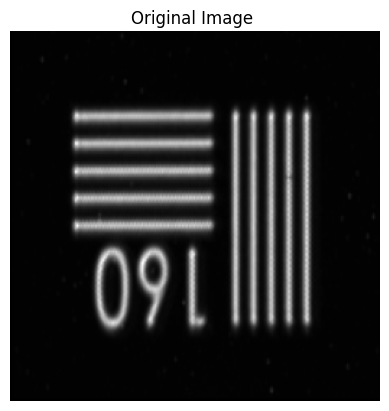

In [34]:
# Function to calculate PSNR
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr

# Ask the user which noise to add
noise_type = input("Which noise do you want to add? 'g' for Gaussian, 'p' for Poisson, 'u' for Uniform, and 'n' for None: ").strip().lower()
noise_level = 0.2  # Adjust the noise level as needed
torch.manual_seed(42)
def add_noise(x, noise_type, noise_level):
    if noise_level == 0.0:
        return x
    if noise_type == 'g':
        noisy = x + torch.normal(0, noise_level / 255, x.shape)
        noisy = torch.clamp(noisy, 0, 1)
    elif noise_type == 'p':
        noisy = torch.poisson(noise_level * x) / noise_level
        noisy = torch.clamp(noisy, 0, 1)
        print(noisy)
    elif noise_type == 'u':
        noisy = x + torch.rand_like(x) * noise_level - (noise_level / 2)
        noisy = torch.clamp(noisy, 0, 1)
    else:
        return x
    return noisy

if noise_type == 'n':
    noisy_img = clean_img
    calculate_psnr_flag = False
    title = 'Original Image'
else:
    noisy_img = add_noise(clean_img, noise_type, noise_level)
    calculate_psnr_flag = True
    title = 'Noisy Image'

if noisy_img is not None:
    print(noisy_img.dtype)
    if calculate_psnr_flag:
        psnr_value = calculate_psnr(clean_img, noisy_img)
        psnr_text = f"PSNR: {psnr_value:.2f} dB"
    else:
        psnr_text = ''

    # Display the image with the correct title and PSNR value
    plt.imshow(noisy_img.cpu().squeeze(0).permute(1, 2, 0), cmap='gray')  # Show color or grayscale image
    plt.title(f"{title} {psnr_text}")
    plt.axis('off')
    plt.show()
else:
    print("No image to display.")

# Move images to the specified device
if clean_img is not None:
    clean_img = clean_img.to(device)
if noisy_img is not None:
    noisy_img = noisy_img.to(device)


# **Step 6: Define the network, which is a 2 layer CNN**

In [35]:
class Network(nn.Module):
    def __init__(self, n_chan, chan_embed=48):
        super(Network, self).__init__()
        self.act = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.conv1 = nn.Conv2d(n_chan, chan_embed, 3, padding=1)
        self.conv2 = nn.Conv2d(chan_embed, chan_embed, 3, padding=1)
        self.conv3 = nn.Conv2d(chan_embed, n_chan, 1)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        x = self.conv3(x)
        return x

# Initialize the model and move it to the specified device
if clean_img is not None:
    n_chan = clean_img.shape[1]
    model = Network(n_chan)
    model = model.to(device)
    print("The number of parameters of the network is: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
else:
    print("No clean image loaded, skipping model initialization.")

The number of parameters of the network is:  21313


# **Step 7: Define the pair downsampler function**

We now introduce the image pair downsampler, which produces two downsampled images with half the original spatial resolution by averaging diagonal pixels in non-overlapping patches, as illustrated in the figure below.

This is achieved by convolving the image with two fixed kernels:  $k_1 = \begin{bmatrix}0 & 0.5 \\0.5 & 0\end{bmatrix}$ and $k_2 = \begin{bmatrix}0.5 & 0 \\0 & 0.5\end{bmatrix}$. The convolution is performed with a stride of 2 and is applied separately to each image channel.

In [36]:
def pair_downsampler(img):
    c = img.shape[1]
    filter1 = torch.FloatTensor([[[[0, 0.5], [0.5, 0]]]]).to(img.device).repeat(c, 1, 1, 1)
    filter2 = torch.FloatTensor([[[[0.5, 0], [0, 0.5]]]]).to(img.device).repeat(c, 1, 1, 1)
    output1 = F.conv2d(img, filter1, stride=2, groups=c)
    output2 = F.conv2d(img, filter2, stride=2, groups=c)
    return output1, output2

# **Step 8: Display noisy image and its corresponding downsampled pair**

If the original image size is 256 x 256, it is indicated on the scale that the resolution of the downsampled images is half of that, i.e., 128 x 128. This reduction in resolution is achieved through the downsampling process, which averages diagonal pixels in non-overlapping patches.

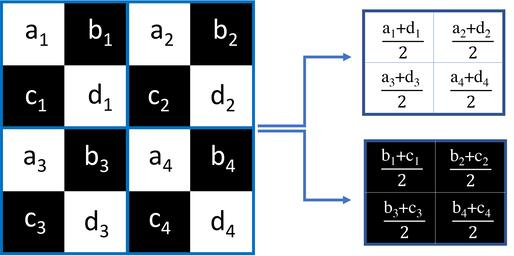

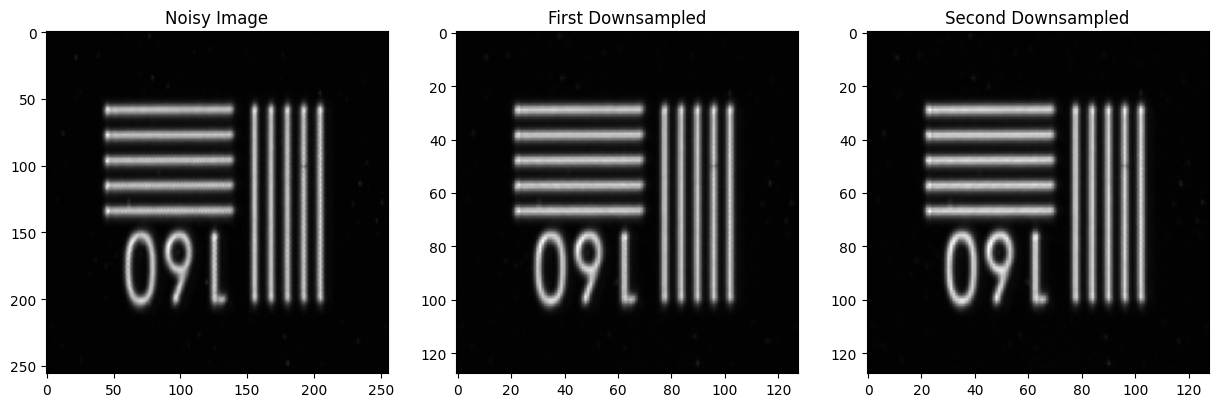

In [37]:
if noisy_img is not None:
    img1, img2 = pair_downsampler(noisy_img)

    img0 = noisy_img.cpu().squeeze(0).permute(1, 2, 0)
    img1 = img1.cpu().squeeze(0).permute(1, 2, 0)
    img2 = img2.cpu().squeeze(0).permute(1, 2, 0)

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))

    ax[0].imshow(img0, cmap='gray')
    ax[0].set_title('Noisy Image')

    ax[1].imshow(img1, cmap='gray')
    ax[1].set_title('First Downsampled')

    ax[2].imshow(img2, cmap='gray')
    ax[2].set_title('Second Downsampled')

    plt.show()
else:
    print("No noisy image available for downsampling.")

# **Step 9: Define the MSE loss function**

# Mean Squared Error (MSE) Calculation

The "mse" function calculates the Mean Squared Error (MSE) between two tensors. MSE is a commonly used loss function that measures the average squared difference between the actual (ground truth) and predicted values.

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$


In [38]:
def mse(gt: torch.Tensor, pred: torch.Tensor) -> torch.Tensor:
    loss = torch.nn.MSELoss()
    return loss(gt, pred)

# **Step 10: Define the custom loss function**

The loss function is the sum of a residual loss plus a consistency loss as follows:

$$     \mathcal{L}_\mathrm{res.}(\theta) =\frac{1}{2}\left( \|D_1({y}) - f_{\theta}(D_1({y})) - D_2({y})\|_2^2 + \|D_2({y}) - f_{\theta}(D_2({y})) - D_1({y})\|_2^2 \right). $$

$$     \mathcal{L}_\mathrm{cons.}(\theta) = \frac{1}{2} \left( \|f_{\theta}(D_1({y})) - D_1(f_{\theta}({y}))\|_2^2 + \|f_{\theta}(D_2({y})) - D_2(f_{\theta}({y}))\|_2^2 \right). $$

$$ \mathcal{L}(\theta) = \mathcal{L}_\mathrm{res.}(\theta) + \mathcal{L}_\mathrm{cons.}(\theta), $$

where $y$ is the noisy input image, $D$ is the image pair downsampler, and $f_\theta$ is the network.

In [39]:
def loss_func(noisy_img):
    noisy1, noisy2 = pair_downsampler(noisy_img)

    pred1 =  noisy1 - model(noisy1)
    pred2 =  noisy2 - model(noisy2)

    loss_res = 1/2*(mse(noisy1, pred2) + mse(noisy2, pred1))

    noisy_denoised =  noisy_img - model(noisy_img)
    denoised1, denoised2 = pair_downsampler(noisy_denoised)

    loss_cons = 1/2*(mse(pred1, denoised1) + mse(pred2, denoised2))

    loss = loss_res + loss_cons

    return loss

# **Step 11: Define Training, Testing, and Denoising Functions**

In [40]:
def train(model, optimizer, noisy_img):
    loss = loss_func(noisy_img)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def test(model, noisy_img, clean_img):
    with torch.no_grad():
        pred = torch.clamp(noisy_img - model(noisy_img), 0, 1)
        MSE = mse(clean_img, pred).item()
        PSNR = 10 * np.log10(1 / MSE)
    return PSNR

def denoise(model, noisy_img):
    with torch.no_grad():
        pred = torch.clamp(noisy_img - model(noisy_img), 0, 1)
    return pred

# **Step 12: Set Up Training Parameters**

In [41]:
if noisy_img is not None and clean_img is not None:
    max_epoch = 3000  # training epochs
    lr = 0.001  # learning rate
    step_size = 1000  # number of epochs at which learning rate decays
    gamma = 0.5  # factor by which learning rate decays

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# **Step 13: Training Process**

In [42]:
    for epoch in tqdm(range(max_epoch)):
        train_loss = train(model, optimizer, noisy_img)
        scheduler.step()

#        if (epoch + 1) % 100 == 0:
#            print(f"Epoch {epoch+1}, Training Loss: {train_loss}")

  0%|          | 0/3000 [00:00<?, ?it/s]

# **Step 14: Convert Images to CPU and Permute Dimensions**

In this step, the denoised and clean images are moved from the GPU to the CPU using .cpu(). This is necessary because "matplotlib", the library used for visualization, operates on CPU tensors and does not directly support GPU tensors.

In [43]:
denoised_img = denoise(model, noisy_img)
denoised = denoised_img.cpu().squeeze(0).permute(1, 2, 0)
clean = clean_img.cpu().squeeze(0).permute(1, 2, 0)
noisy = noisy_img.cpu().squeeze(0).permute(1, 2, 0)

# **Step 15: Visualization with PSNR Calculation**

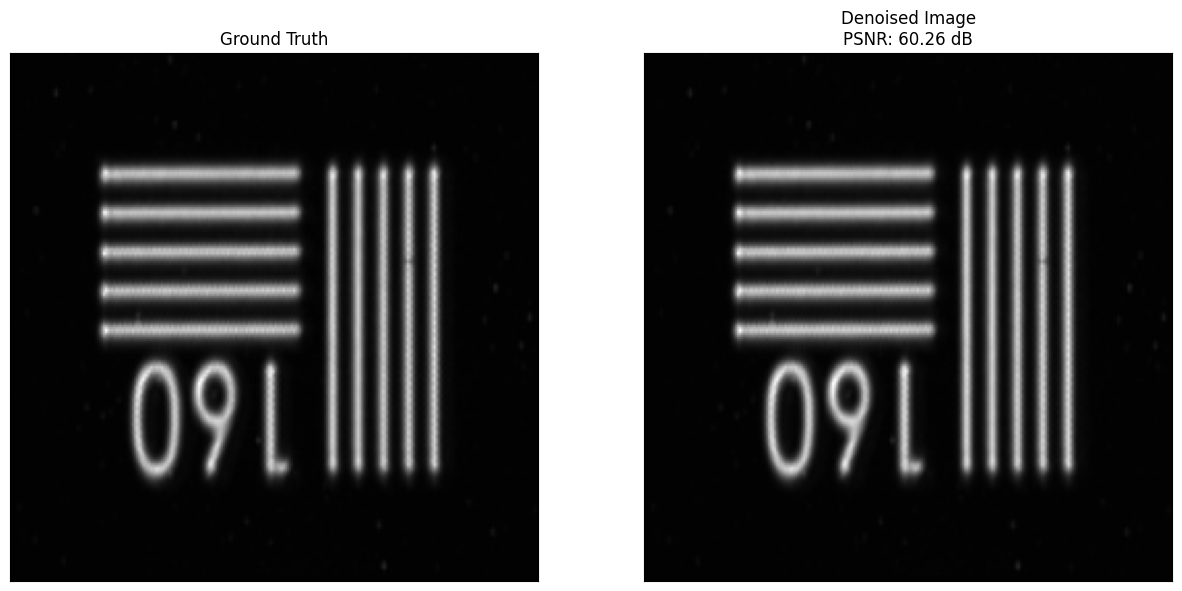

In [44]:
# Calculate PSNR value for denoised image
psnr_denoised = calculate_psnr(clean_img, denoised_img)

if noise_type == 'n':
    # Display the ground truth and denoised images only
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))

    ax[0].imshow(clean, cmap='gray')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Ground Truth')

    ax[1].imshow(denoised, cmap='gray')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title(f'Denoised Image\nPSNR: {psnr_denoised:.2f} dB')

    plt.show()
else:
    noisy = noisy_img.cpu().squeeze(0).permute(1, 2, 0)
    # Calculate PSNR value for noisy image
    psnr_noisy = calculate_psnr(clean_img, noisy_img)

    # Display the ground truth, noisy, and denoised images
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))

    ax[0].imshow(clean, cmap='gray')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Ground Truth')

    ax[1].imshow(noisy, cmap='gray')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title(f'Noisy Image\nPSNR: {psnr_noisy:.2f} dB')

    ax[2].imshow(denoised, cmap='gray')
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title(f'Denoised Image\nPSNR: {psnr_denoised:.2f} dB')

    plt.show()
